# Daisyworld
The following notebook implements the original version of the Daisyworld climate model, as presented in the article Biological homeostasis of the global environment: the parable of Daisyworld, written by Lovelock and Watson in the early 1980s.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import configparser

sigma = 5.67e-8
kelvin = 273

## Function definition
The following function allows extraction of the simulation parameters from a configuration file.

In [12]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values

Definition of the growth rate as a function of local temperature.

In [13]:
def growth_rate(T_p, T_opt, beta_coeff):
    var = k * (T_p - T_opt)**2
    if var < 1:
        return 1. - var
    else:
        return 0.

Functions to compute the planetary albedo, the planetary temperature in degrees Celsius, and the local temperature using the approximated linearised expression.

In [14]:
def planetary_albedo(albedo, area):
    return sum(albedo[i] * area[i] for i in range(len(albedo)))

def planetary_temperature_C(a_p, L, S):
    return (L * S / sigma * (1 - a_p))**0.25 - kelvin

def linear_local_temperature_C(albedo_l, a_p, Tc_p, q):
    return  q * (a_p - albedo_l) + (Tc_p)

## Simulation
In the following cell, we extract the parameters of the simulation from the configuration file. The evolution over time is carried out for 100 epochs, each epoch corresponding to a single time step. 

In [60]:
config = configparser.ConfigParser()
config.read('config.ini')

albedo = extract_values('albedo', config)
a_w, a_b, a_g = albedo
area = extract_values('initial_area', config)
alpha_w, alpha_b = area
alpha_g = 1 - alpha_w - alpha_b
temp = extract_values('temperature_celsius', config)
Tc_min, Tc_max, Tc_opt = temp
lum = extract_values('luminosity', config)
L_min, L_max, delta_L = lum
par = extract_values('other_parameters', config)
gamma, q, S = par
k = 1. / ((Tc_max - Tc_min) / 2)**2

delta_t = 1.
n_iterations = 100

The planetary temperature of the lifeless planet is computed at each luminosity by neglecting the population dynamics of the two types of daisies and setting their albedo equal to a_g, the albedo of the barren soil.

In [61]:
luminosities = np.arange(L_min, L_max, delta_L)

Tc_p_lifeless = [float(planetary_temperature_C(a_g, L, S)) for L in luminosities]

## Forward evolution
Simulation with progressively increasing luminosity.

In [62]:
area_w, area_b, area_g = [], [], []
planetary_Tc = []

for L in luminosities:
    count = 0
    
    alpha_w = max(0.01, alpha_w)
    alpha_b = max(0.01, alpha_b)
    alpha_g = 1 - alpha_w - alpha_b

    for count in range(n_iterations):

        area = [alpha_w, alpha_b, alpha_g]

        a_p = planetary_albedo(albedo, area)
        Tc_p = planetary_temperature_C(a_p, L, S)

        Tc_w = linear_local_temperature_C(a_w, a_p, Tc_p, q)
        Tc_b = linear_local_temperature_C(a_b, a_p, Tc_p, q)

        beta_w = growth_rate(Tc_w, Tc_opt, k)
        beta_b = growth_rate(Tc_b, Tc_opt, k)

        alpha_w += alpha_w * delta_t * (beta_w * alpha_g - gamma)
        alpha_b += alpha_b * delta_t * (beta_b * alpha_g - gamma)
        alpha_g = 1 - alpha_w - alpha_b

        count += 1

    area_w.append(alpha_w)
    area_b.append(alpha_b)
    area_g.append(alpha_g)
    planetary_Tc.append(Tc_p)

percentage_area_w_forward = [float(value * 100) for value in area_w]
percentage_area_b_forward = [float(value * 100) for value in area_b]
percentage_area_g_forward = [float(value * 100) for value in area_g]
planetary_Tc_forward = [float(value) for value in planetary_Tc]

## Backward evolution
Simulation with progressively decreasing luminosity.

In [63]:
area_w.clear()
area_b.clear()
area_g.clear()
planetary_Tc.clear()

alpha_w, alpha_b = [0.01, 0.01]
alpha_g = 1 - alpha_w - alpha_b

luminosities_backward = luminosities[::-1]

for L in luminosities_backward:
    count = 0
    
    alpha_w = max(0.01, alpha_w)
    alpha_b = max(0.01, alpha_b)
    alpha_g = 1 - alpha_w - alpha_b

    for count in range(n_iterations):

        area = [alpha_w, alpha_b, alpha_g]

        a_p = planetary_albedo(albedo, area)
        Tc_p = planetary_temperature_C(a_p, L, S)

        Tc_w = linear_local_temperature_C(a_w, a_p, Tc_p, q)
        Tc_b = linear_local_temperature_C(a_b, a_p, Tc_p, q)

        beta_w = growth_rate(Tc_w, Tc_opt, k)
        beta_b = growth_rate(Tc_b, Tc_opt, k)

        alpha_w += alpha_w * delta_t * (beta_w * alpha_g - gamma)
        alpha_b += alpha_b * delta_t * (beta_b * alpha_g - gamma)
        alpha_g = 1 - alpha_w - alpha_b

        count += 1
        
# Save states
    area_w.append(alpha_w)
    area_b.append(alpha_b)
    area_g.append(alpha_g)
    planetary_Tc.append(Tc_p)

percentage_area_w_backward = [float(value * 100) for value in area_w]
percentage_area_b_backward = [float(value * 100) for value in area_b]
percentage_area_g_backward = [float(value * 100) for value in area_g]
planetary_Tc_backward = [float(value) for value in planetary_Tc]

Plot of the results: for both increasing and decreasing luminosities, we can observe the percentage of area covered by the two types of daisies, as well as the change in planetary temperature for the planet with and without biota.

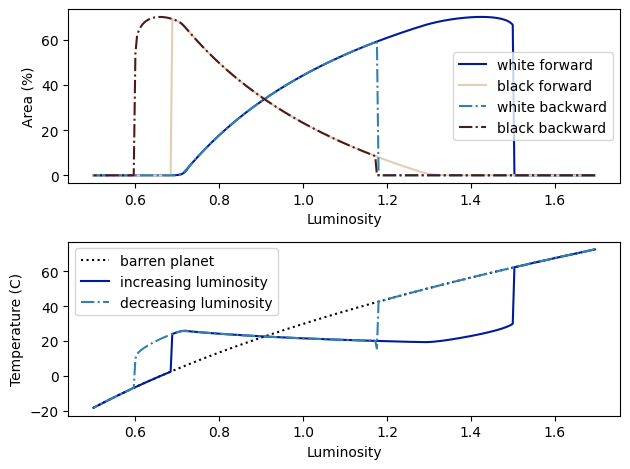

In [64]:
fig, axes = plt.subplots(2, 1)

axes[0].plot(luminosities, percentage_area_w_forward, color=(0.0, 0.1, 0.6), label='white forward', linestyle='-')
axes[0].plot(luminosities, percentage_area_b_forward, color=(0.9, 0.8, 0.7), label='black forward', linestyle='-')
axes[0].plot(luminosities_backward, percentage_area_w_backward, color=(0.2, 0.5, 0.7), label='white backward', linestyle='-.')
axes[0].plot(luminosities_backward, percentage_area_b_backward,  color=(0.3, 0.1, 0.1), label='black backward', linestyle='-.')
axes[0].set_ylabel('Area (%)')
axes[0].set_xlabel('Luminosity')
axes[0].legend()

axes[1].plot(luminosities, Tc_p_lifeless, color='black', label='barren planet', linestyle=':')
axes[1].plot(luminosities, planetary_Tc_forward, color=(0.0, 0.1, 0.6), label='increasing luminosity')
axes[1].plot(luminosities_backward, planetary_Tc_backward, color=(0.2, 0.5, 0.7), label='decreasing luminosity', linestyle='-.')
axes[1].set_xlabel('Luminosity')
axes[1].set_ylabel('Temperature (C)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Daisyworld revisited
In the following cells, some simple modifications to the original model are implemented.
The first modification involves a variation in the feedback. It is assumed that clouds with a higher albedo than that of the white daisies form above the black daisies.

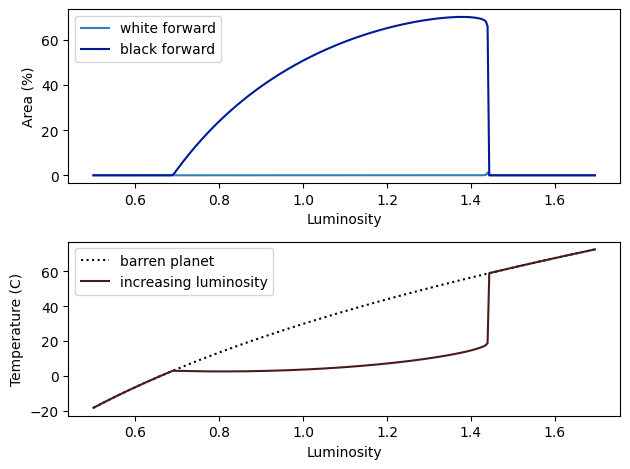

In [66]:
area_w, area_b, area_g = [], [], []
planetary_Tc = []

real_albedo = albedo.copy()
albedo_cloud = 0.8
#Replace the albedo of the black daisies with that of the clouds
real_albedo[1] = albedo_cloud

for L in luminosities:
    count = 0
    
    alpha_w = max(0.01, alpha_w)
    alpha_b = max(0.01, alpha_b)
    alpha_g = 1 - alpha_w - alpha_b

    for count in range(n_iterations):

        area = [alpha_w, alpha_b, alpha_g]

        a_p = planetary_albedo(real_albedo, area)
        Tc_p = planetary_temperature_C(a_p, L, S)

        Tc_w = linear_local_temperature_C(a_w, a_p, Tc_p, q)
        Tc_b = linear_local_temperature_C(a_b, a_p, Tc_p, q)

        beta_w = growth_rate(Tc_w, Tc_opt, k)
        beta_b = growth_rate(Tc_b, Tc_opt, k)

        alpha_w += alpha_w * delta_t * (beta_w * alpha_g - gamma)
        alpha_b += alpha_b * delta_t * (beta_b * alpha_g - gamma)
        alpha_g = 1 - alpha_w - alpha_b

        count += 1

    area_w.append(alpha_w)
    area_b.append(alpha_b)
    area_g.append(alpha_g)
    planetary_Tc.append(Tc_p)

percentage_area_w_forward = [float(value * 100) for value in area_w]
percentage_area_b_forward = [float(value * 100) for value in area_b]
percentage_area_g_forward = [float(value * 100) for value in area_g]
planetary_Tc_forward = [float(value) for value in planetary_Tc]

fig, axes = plt.subplots(2, 1)

axes[0].plot(luminosities, percentage_area_w_forward, color=(0.2, 0.5, 0.7), label='white forward', linestyle='-')
axes[0].plot(luminosities, percentage_area_b_forward, color=(0.0, 0.1, 0.6), label='black forward', linestyle='-')
axes[0].set_ylabel('Area (%)')
axes[0].set_xlabel('Luminosity')
axes[0].legend()

axes[1].plot(luminosities, Tc_p_lifeless, color='black', label='barren planet', linestyle=':')
axes[1].plot(luminosities, planetary_Tc_forward, color=(0.3, 0.1, 0.1), label='increasing luminosity')
axes[1].set_xlabel('Luminosity')
axes[1].set_ylabel('Temperature (C)')
axes[1].legend()

plt.tight_layout()

#plt.savefig('clouds')

plt.show()

The following variation introduces the phenomenon of interspecific competition between the two types of daisies. The coefficients ww and bb are set to 1, as they relate to intraspecific competition.

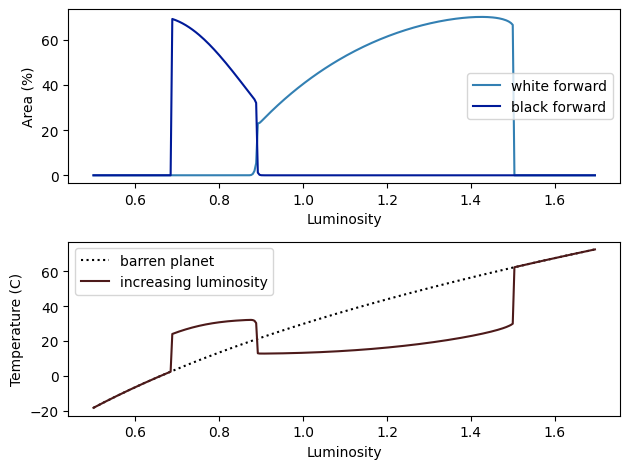

In [70]:
area_w, area_b, area_g = [], [], []
planetary_Tc = []

ww, bb, bw, wb = 1, 1, 2, 3

for L in luminosities:
    count = 0
    
    alpha_w = max(0.01, alpha_w)
    alpha_b = max(0.01, alpha_b)
    alpha_g = 1 - alpha_w - alpha_b

    for count in range(n_iterations):

        area = [alpha_w, alpha_b, alpha_g]

        a_p = planetary_albedo(albedo, area)
        Tc_p = planetary_temperature_C(a_p, L, S)

        Tc_w = linear_local_temperature_C(a_w, a_p, Tc_p, q)
        Tc_b = linear_local_temperature_C(a_b, a_p, Tc_p, q)

        beta_w = growth_rate(Tc_w, Tc_opt, k)
        beta_b = growth_rate(Tc_b, Tc_opt, k)

        competition_coefficient_w = 1 - bw * alpha_b - ww * alpha_w 
        competition_coefficient_b = 1 - bb * alpha_b - wb * alpha_w 

        alpha_w += alpha_w * delta_t * (beta_w * competition_coefficient_w - gamma)
        alpha_b += alpha_b * delta_t * (beta_b * competition_coefficient_b - gamma)
        alpha_g = 1 - alpha_w - alpha_b

        count += 1

    area_w.append(alpha_w)
    area_b.append(alpha_b)
    area_g.append(alpha_g)
    planetary_Tc.append(Tc_p)

percentage_area_w_forward = [float(value * 100) for value in area_w]
percentage_area_b_forward = [float(value * 100) for value in area_b]
percentage_area_g_forward = [float(value * 100) for value in area_g]
planetary_Tc_forward = [float(value) for value in planetary_Tc]

fig, axes = plt.subplots(2, 1)

axes[0].plot(luminosities, percentage_area_w_forward, color=(0.2, 0.5, 0.7), label='white forward', linestyle='-')
axes[0].plot(luminosities, percentage_area_b_forward, color=(0.0, 0.1, 0.6), label='black forward', linestyle='-')
axes[0].set_ylabel('Area (%)')
axes[0].set_xlabel('Luminosity')
axes[0].legend()

axes[1].plot(luminosities, Tc_p_lifeless, color='black', label='barren planet', linestyle=':')
axes[1].plot(luminosities, planetary_Tc_forward, color=(0.3, 0.1, 0.1), label='increasing luminosity')
axes[1].set_xlabel('Luminosity')
axes[1].set_ylabel('Temperature (C)')
axes[1].legend()

plt.tight_layout()

#plt.savefig('interspecific_competition')

plt.show()

The final model implemented is a revisited version of Daisyworld that introduces 'cheats': daisies with the same albedo as the ground and an increased growth factor due to not needing to use resources for pigmentation.

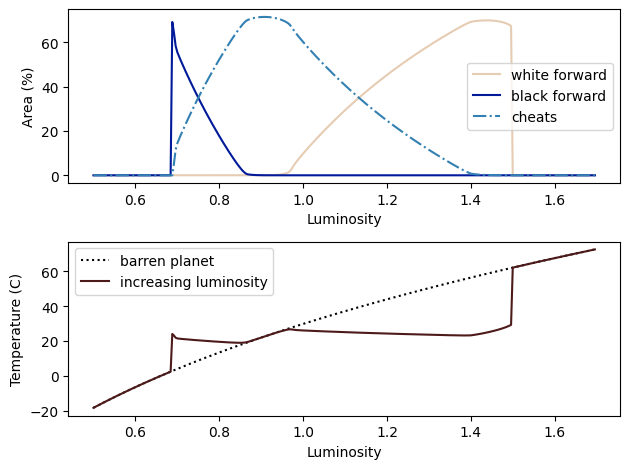

In [72]:
area_w, area_b, area_c, area_g = [], [], [], []
planetary_Tc = []

alpha_c = 0.01
a_c = a_g

albedo_with_cheats = [a_w, a_b, a_c, a_g]

for L in luminosities:
    count = 0
    
    alpha_w = max(0.01, alpha_w)
    alpha_b = max(0.01, alpha_b)
    alpha_c = max(0.01, alpha_c)
    alpha_g = 1 - alpha_w - alpha_b - alpha_c

    for count in range(n_iterations):

        area = [alpha_w, alpha_b, alpha_c, alpha_g]

        a_p = planetary_albedo(albedo_with_cheats, area)
        Tc_p = planetary_temperature_C(a_p, L, S)

        Tc_w = linear_local_temperature_C(a_w, a_p, Tc_p, q)
        Tc_b = linear_local_temperature_C(a_b, a_p, Tc_p, q)
        Tc_c = linear_local_temperature_C(a_c, a_p, Tc_p, q)

        beta_w = growth_rate(Tc_w, Tc_opt, k)
        beta_b = growth_rate(Tc_b, Tc_opt, k)
        beta_c = 1.05 * growth_rate(Tc_c, Tc_opt, k)

        alpha_w += alpha_w * delta_t * (beta_w * alpha_g - gamma)
        alpha_b += alpha_b * delta_t * (beta_b * alpha_g - gamma)
        alpha_c += alpha_c * delta_t * (beta_c * alpha_g - gamma)
        alpha_g = 1 - alpha_w - alpha_b - alpha_c

        count += 1

    area_w.append(alpha_w)
    area_b.append(alpha_b)
    area_c.append(alpha_c)
    area_g.append(alpha_g)
    planetary_Tc.append(Tc_p)

percentage_area_w_forward = [float(value * 100) for value in area_w]
percentage_area_b_forward = [float(value * 100) for value in area_b]
percentage_area_c_forward = [float(value * 100) for value in area_c]
percentage_area_g_forward = [float(value * 100) for value in area_g]
planetary_Tc_forward = [float(value) for value in planetary_Tc]

fig, axes = plt.subplots(2, 1)

axes[0].plot(luminosities, percentage_area_w_forward, color=(0.9, 0.8, 0.7), label='white forward', linestyle='-')
axes[0].plot(luminosities, percentage_area_b_forward, color=(0.0, 0.1, 0.6), label='black forward', linestyle='-')
axes[0].plot(luminosities, percentage_area_c_forward, color=(0.2, 0.5, 0.7), label='cheats', linestyle='-.')
axes[0].set_ylabel('Area (%)')
axes[0].set_xlabel('Luminosity')
axes[0].legend()

axes[1].plot(luminosities, Tc_p_lifeless, color='black', label='barren planet', linestyle=':')
axes[1].plot(luminosities, planetary_Tc_forward, color=(0.3, 0.1, 0.1), label='increasing luminosity')
axes[1].set_xlabel('Luminosity')
axes[1].set_ylabel('Temperature (C)')
axes[1].legend()

plt.tight_layout()

#plt.savefig('cheats')

plt.show()